# Adv. Convex Optimization - Homework 2
### Cooper Simpson

Our goal is to compare least squares (i.e. $\ell_2$) regression and $\ell_1$ regression -- the forms of which are given below.

$$
\ell_1\text{ regression: }\beta_1 = argmin||X\beta-y||_1\\
\text{Least Squares: } \beta_2 = argmin||X\beta-y||_2
$$

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvp
from scipy import stats

sns.set()

## Data

First, we load our data into a dataframe and examine some of its basic qualities.

In [2]:
wine_df = pd.read_csv("winequality-white.csv", sep=';')
r, c = wine_df.shape

In [3]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [80]:
wine_df.describe().round(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000
mean,6.855,0.278,0.334,6.391,0.046,35.308,138.361,0.994,3.188,0.490,10.514,5.878
std,0.844,0.101,0.121,5.072,0.022,17.007,42.498,0.003,0.151,0.114,1.231,0.886
min,3.800,0.080,0.000,0.600,0.009,2.000,9.000,0.987,2.720,0.220,8.000,3.000
25%,6.300,0.210,0.270,1.700,0.036,23.000,108.000,0.992,3.090,0.410,9.500,5.000
50%,6.800,0.260,0.320,5.200,0.043,34.000,134.000,0.994,3.180,0.470,10.400,6.000
75%,7.300,0.320,0.390,9.900,0.050,46.000,167.000,0.996,3.280,0.550,11.400,6.000
max,14.200,1.100,1.660,65.800,0.346,289.000,440.000,1.039,3.820,1.080,14.200,9.000


We can see that each data point has 12 associated features, and in total we have almost 5,000 examples. Our goal is to estimate the quality feature of an example using the 11 other features.

## Regression

We define our regression problems below as minimizing etheir the 1 or 2 norm of $Xb-y$. The rows of $X$ are our examples, the columns the 11 defining features, $y$ the associated quality, and $b$ our regression variable.

In [65]:
#Setup matrices and define minimization problems using CVXPY
def reg(df, vb=False):
    X = df.loc[:,:'alcohol'].to_numpy()
    y = df.loc[:,'quality'].to_numpy()

    b1 = cvp.Variable(c-1,)
    b2 = cvp.Variable(c-1,)
    obj1 = cvp.Minimize(cvp.norm(X@b1-y, 1))
    obj2 = cvp.Minimize(cvp.norm(X@b2-y))

    prob1 = cvp.Problem(obj1, [])
    prob2 = cvp.Problem(obj2, [])
    
    prob1.solve(verbose=vb)
    prob2.solve(verbose=vb)
    
    return b1.value, b2.value

In [9]:
#Solve minimization problems and extract estimators
b1, b2 = reg(wine_df)

## Analysis

Having solved our minimization problem we now want to analyze the results. Below we can see a table with the estimators for each attribute as generated by the two problems.

In [46]:
pd.DataFrame([b1,b2,np.abs(b1-b2)], ['b 1-norm', 'b 2-norm', 'Diff'], wine_df.columns[:11])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
b 1-norm,-0.028980,-2.074623,-0.165467,0.027271,-1.742145,0.005338,-0.000913,1.156920,0.397387,0.559358,0.364033
b 2-norm,-0.050591,-1.958510,-0.029349,0.024988,-0.942584,0.004791,-0.000878,2.042047,0.168395,0.416453,0.365633
Diff,0.021610,0.116113,0.136118,0.002282,0.799561,0.000547,0.000035,0.885126,0.228992,0.142905,0.001600


It is clear that our two methods have similar results in some attributes (e.g. residual sugar and alcohol), while others differ quite a lot (e.g. density and chlorides). We are interested in qualifying how well our two estimators are performing, and their relative differences. To do this we will examine the residuals of the final estimator.

In [68]:
A = wine_df.loc[:,:'alcohol'].to_numpy()
y = wine_df.loc[:,'quality'].to_numpy()

r1 = A@b1 - y
r2 = A@b2 - y

print('1-norm Number Incorrect: ',np.linalg.norm(np.around(r1),1))
print('2-norm Number Incorrect: ',np.linalg.norm(np.around(r2),1))

1-norm Number Incorrect:  2628.0
2-norm Number Incorrect:  2631.0


Given that the quality attribute is a discrete value we first round our residuals to the nearest integer, and then examine the 1-norm. We can see that they are making about the same number of incorrect predicitons -- which is about half of the data. 

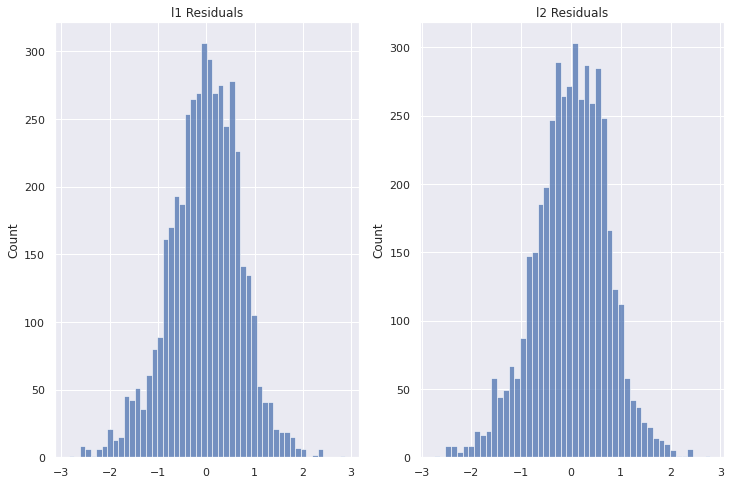

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
sns.histplot(x=r1, ax=ax[0])
sns.histplot(x=r2, ax=ax[1])

ax[0].set_title('l1 Residuals')
ax[1].set_title('l2 Residuals');

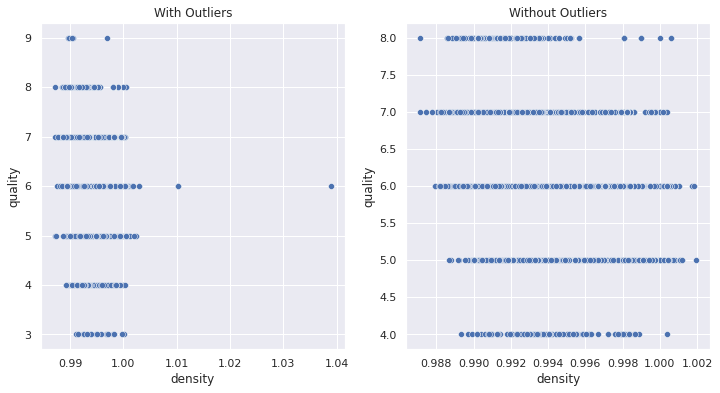

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(x='density', y='quality', data=wine_df, ax=ax[0])

z = np.abs(stats.zscore(wine_df))
wine_df_o = wine_df[(z < 3).all(axis=1)]

sns.scatterplot(x='density', y='quality', data=wine_df_o, ax=ax[1])

ax[0].set_title('With Outliers')
ax[1].set_title('Without Outliers');

In the figures above we see quality plotted against the density feature. On the left we can clearly see two significant outliers. Examination of the other attributes show this is not limited to the density feature. We remove these outliers by removing data that is more than three standard deviations from the mean, and on the right we see the result for the density feature. Lets try to re-run the regression having hopefully removed the outliers in our data.

In [66]:
b1_o, b2_o = reg(wine_df_o)

In [75]:
pd.DataFrame([b1_o,b2_o,np.abs(b1_o-b2_o)], ['1-norm', '2-norm', 'Diff'], wine_df.columns[:11])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1-norm,-0.007381,-1.915205,0.032697,0.028823,-6.326302,0.006167,-0.000946,0.740972,0.512398,0.669023,0.355596
2-norm,-0.025006,-1.770778,-0.023527,0.026326,-5.270536,0.006037,-0.000689,1.596757,0.307160,0.423343,0.355452
Diff,0.017625,0.144427,0.056224,0.002497,1.055766,0.000130,0.000257,0.855785,0.205239,0.245680,0.000144


On a first glance this doesn't appear to have changed the estimators too much, but lets repeat our residual analysis.

In [71]:
A = wine_df_o.loc[:,:'alcohol'].to_numpy()
y = wine_df_o.loc[:,'quality'].to_numpy()

r1 = A@b1_o - y
r2 = A@b2_o - y

print('1-norm Number Incorrect: ',np.linalg.norm(np.around(r1),1))
print('2-norm Number Incorrect: ',np.linalg.norm(np.around(r2),1))

1-norm Number Incorrect:  2391.0
2-norm Number Incorrect:  2409.0


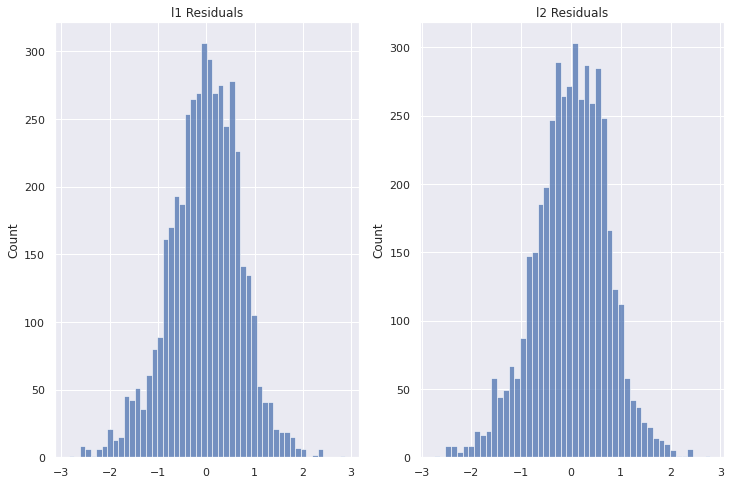

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
sns.histplot(x=r1, ax=ax[0])
sns.histplot(x=r2, ax=ax[1])

ax[0].set_title('l1 Residuals')
ax[1].set_title('l2 Residuals');

It certainly appears that removing the outliers has increased the prediction ability of our model, which makes sense. Overall, based on my analysis, it is not immediately obvious what separates our two regression methods. It does appear that $\ell_1$ is doing a better job at prediction, but besides that it is not immediately clear if one is overall a better approach in this situation.